<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/04_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jun  4 15:34:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-04 15:34:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   129MB/s    in 1.2s    

2022-06-04 15:34:23 (129 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(len(dirnames), "directories\t", len(filenames), "images\t", dirpath)

2 directories	 0 images	 10_food_classes_10_percent
10 directories	 0 images	 10_food_classes_10_percent/train
0 directories	 75 images	 10_food_classes_10_percent/train/chicken_curry
0 directories	 75 images	 10_food_classes_10_percent/train/steak
0 directories	 75 images	 10_food_classes_10_percent/train/sushi
0 directories	 75 images	 10_food_classes_10_percent/train/fried_rice
0 directories	 75 images	 10_food_classes_10_percent/train/ice_cream
0 directories	 75 images	 10_food_classes_10_percent/train/hamburger
0 directories	 75 images	 10_food_classes_10_percent/train/chicken_wings
0 directories	 75 images	 10_food_classes_10_percent/train/ramen
0 directories	 75 images	 10_food_classes_10_percent/train/pizza
0 directories	 75 images	 10_food_classes_10_percent/train/grilled_salmon
10 directories	 0 images	 10_food_classes_10_percent/test
0 directories	 250 images	 10_food_classes_10_percent/test/chicken_curry
0 directories	 250 images	 10_food_classes_10_percent/test/steak
0 dir

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  return tensorboard_callback

In [6]:
res_net = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficient_net = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(
      model_url, 
      trainable=False,
      name="feature_extraction_layer",
      input_shape=IMAGE_SHAPE+(3,)
      )
  
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [9]:
resnet_model = create_model(res_net)

In [10]:
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [11]:
history_1 = resnet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet50v2")]
    )

Epoch 1/5
24/24 [==============================] - 32s 755ms/step - loss: 1.9265 - accuracy: 0.3667 - val_loss: 1.2015 - val_accuracy: 0.6300
Epoch 2/5
24/24 [==============================] - 17s 715ms/step - loss: 0.9225 - accuracy: 0.7267 - val_loss: 0.8251 - val_accuracy: 0.7448
Epoch 3/5
24/24 [==============================] - 19s 800ms/step - loss: 0.6200 - accuracy: 0.8200 - val_loss: 0.7597 - val_accuracy: 0.7508
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4831 - accuracy: 0.8733 - val_loss: 0.6967 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 17s 721ms/step - loss: 0.3859 - accuracy: 0.9213 - val_loss: 0.6809 - val_accuracy: 0.7840


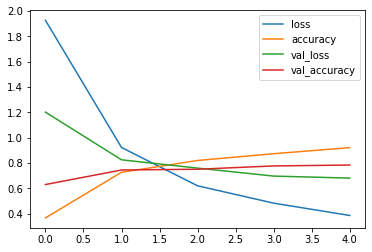

In [12]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

In [13]:
efficientnet_model = create_model(efficient_net)

efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_2 = efficientnet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnet")]
    )

Epoch 1/5
24/24 [==============================] - 26s 723ms/step - loss: 1.9189 - accuracy: 0.4000 - val_loss: 1.3531 - val_accuracy: 0.7012
Epoch 2/5
24/24 [==============================] - 15s 657ms/step - loss: 1.1069 - accuracy: 0.7467 - val_loss: 0.8949 - val_accuracy: 0.8120
Epoch 3/5
24/24 [==============================] - 15s 655ms/step - loss: 0.7830 - accuracy: 0.8200 - val_loss: 0.7167 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 15s 662ms/step - loss: 0.6243 - accuracy: 0.8560 - val_loss: 0.6204 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 16s 675ms/step - loss: 0.5266 - accuracy: 0.8840 - val_loss: 0.5626 - val_accuracy: 0.8620


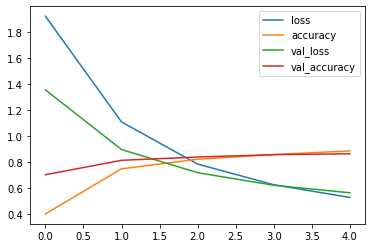

In [14]:
pd.DataFrame(history_2.history).plot()

In [ ]:
!tensorboard dev upload --logdir ./tensor_hub/ \
--name "EfficientNetB0 vs ResNest50v2" \
--description "comparison between models" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensor_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 